# Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

import os
path      = os.getcwd()
ampNumber = int(os.path.basename(path)[0])

originalDataset = pd.read_csv('dataset-{}.txt'.format(ampNumber), sep = ',', header = None)
binaryDataset   = []

/home/leandro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Dataset balancing

In [2]:

def datasetBalancing(dataset):
    newDataset      = []
    linesPerChannel = []
    currentChannel  = 2

    # Finding channel minimum target 
    count = 0
    for line in dataset.values:
        channels = np.count_nonzero(line[0: 40], axis=0)

        if currentChannel == channels:
            count += 1
        else:
            linesPerChannel.append(count)

            currentChannel = channels
            count          = 0

    linesPerChannel.append(count)   
    
    print(linesPerChannel)
    
    guide = np.array(linesPerChannel)
    guide = guide[guide != 0]
    
    showGuides(guide)
    
    target     = min(guide)
    newDataset = cutDown(dataset, guide, target)
    
    return newDataset

def cutDown(dataset, guide, target):
    newDataset   = []
    currentEntry = 0

    for entry in guide:
        #print(currentEntry, currentEntry + target)

        subset = dataset.values[currentEntry : currentEntry + target]
        newDataset.extend(subset)
        currentEntry += entry
    
    return newDataset

def showGuides(guide):
    channels = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40]
    
    for c, g in zip(channels, guide):
        print("{} chs: {} entries".format(c, g))

# Data proccessing

In [3]:
balancedDataset = datasetBalancing(originalDataset)

for line in balancedDataset:
    myList = [1 if j != 0 else 0 for j in line[:40]]
    myList.extend(line[40:])
    binaryDataset.append(myList)

binaryDataset = pd.DataFrame(binaryDataset)

def loadDataset(): 
    dataset = binaryDataset.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataset.values[:, 40 + i])
        gain    = gain.reshape(-1, 1)
        dataset = np.hstack((dataset, gain))
        
        loss    = np.array(binaryDataset.values[:, 40 + i + 1])
        loss    = loss.reshape(-1, 1)
        dataset = np.hstack((dataset, loss))
                
    X, y = np.array(dataset[:, :40]), np.array(dataset[:, 40:])
    return X, y

[48, 23, 24, 24, 25, 22, 23, 28, 23, 21, 24, 24]
2 chs: 48 entries
3 chs: 23 entries
4 chs: 24 entries
5 chs: 24 entries
6 chs: 25 entries
7 chs: 22 entries
8 chs: 23 entries
9 chs: 28 entries
10 chs: 23 entries
15 chs: 21 entries
20 chs: 24 entries
30 chs: 24 entries


# Model setup

In [4]:
summaryList = []

#1 regressor per amplifier
X, y = loadDataset()

for j in range(0, ampNumber * 2):
    reg = LazyRegressor(verbose = 0, ignore_warnings = False)

    X_train, X_test, y_train, y_test = train_test_split(X, y[:, j], test_size = 0.3, random_state = 0)
    models, summary                  = reg.fit(X_train, X_test, y_train, y_test)
    
    summaryList.append(summary)

 84%|████████▎ | 36/43 [00:02<00:00,  9.07it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).
StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 26%|██▌       | 11/43 [00:00<00:00, 43.51it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 84%|████████▎ | 36/43 [00:01<00:00, 20.00it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).
StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 98%|█████████▊| 42/43 [00:03<00:00, 12.54it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 30%|███       | 13/43 [00:00<00:01, 16.81it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


  0%|          | 0/43 [00:00<?, ?it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


  0%|          | 0/43 [00:00<?, ?it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 26%|██▌       | 11/43 [00:00<00:00, 36.71it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 77%|███████▋  | 33/43 [00:02<00:01,  7.44it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


 98%|█████████▊| 42/43 [00:03<00:00,  9.99it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 43/43 [00:03<00:00, 13.57it/s]


In [5]:
finalList = []

'''
if i % 2 ==0 -> it's a gain regressor
else         -> it's a loss regressor
'''

for i in range(0, ampNumber * 2, 2): 
    finalList.append([])

    for j in range(min(len(summaryList[i]['RMSE']), len(summaryList[i + 1]['RMSE']))):
        if summaryList[i]['RMSE'].index[j] in summaryList[i + 1]['RMSE']: #checking if gain model exists in loss dataframe
            
            '''
            summaryList[i]['RMSE'].index[j] -> j model's name for regressor i 
            summaryList[i]['RMSE'][j]       -> j model's RMSE for regressor i
            summaryList[i + 1]['RMSE'][j]   -> j model's RMSE for regressor i + 1
            '''
            
            line = [summaryList[i]['RMSE'].index[j], summaryList[i]['RMSE'][j], summaryList[i + 1]['RMSE'][j]]
            finalList[-1].append(line)
    
#finalList[i][j]       -> [name, gain RMSE, loss RMSE] for model #(j + 1) of amp #(i + 1)
print(finalList[0][0]) #  [name, gain RMSE, loss RMSE] for model #1 of amp #1
print(finalList[1][3]) #  [name, gain RMSE, loss RMSE] for model #4 of amp #2

['KNeighborsRegressor', 0.3734617573601429, 0.39075267807860325]
['GeneralizedLinearRegressor', 1.0070861185509252, 0.9094442899656567]


# Draw table

In [6]:
avgSum = 0

def sort_gain_loss(item):
    return item[1] + item[2]

def prepTable(ampIndex):
    global avgSum
    
    rowLabels = [] # Nomes das linhas
    colLabels = [] # Nomes das colunas   
    values    = [] # Valores das células
    
    colLabels = ["Amp {} Gain".format(ampIndex + 1), "Amp {} Loss".format(ampIndex + 1), "Avg"] 
    
    # TODO: Ordenar esta lista de forma decrescente pela soma de ganho e perda (data[i][1] + data[i][2])
    data = finalList[ampIndex] 
    data.sort(reverse = False, key = sort_gain_loss)
    
    for entry in data:
        model = entry[0]
        gain  = round(entry[1], 3)
        loss  = round(entry[2], 3)
        avg   = round((gain + loss) / 2, 3)
        
        rowLabels.append(model)
        values.append([gain, loss, avg])    
        
    avgSum += (data[0][1] + data[0][2]) / 2
    
    return rowLabels, colLabels, values

In [7]:
def drawTable(ampIndex):
    rows, cols, values = prepTable(ampIndex)
    
    fig = plt.figure(figsize = (15, 5))

    plt.axis("off")
    plt.table(cellText  = values,
             rowLabels = rows,
             colLabels = cols, 
             loc="upper center")
    
    plt.savefig("amp{}-table".format(ampIndex + 1))

Link average error: 0.8251477741364185
Balanced dataset with 252 entries


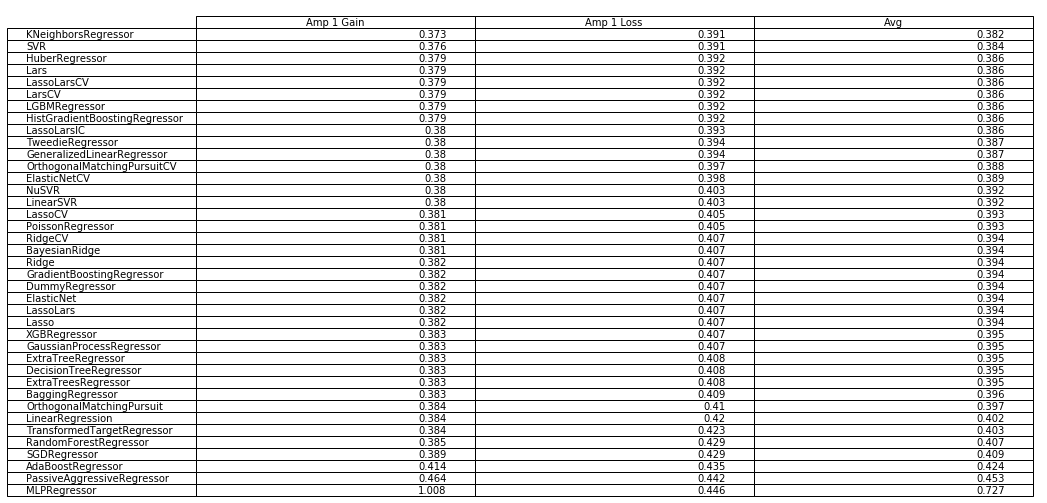

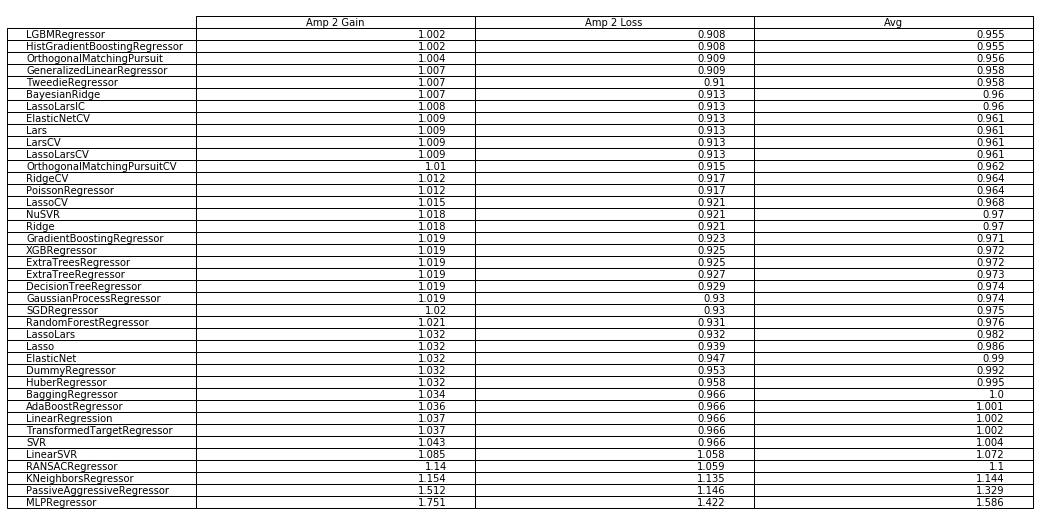

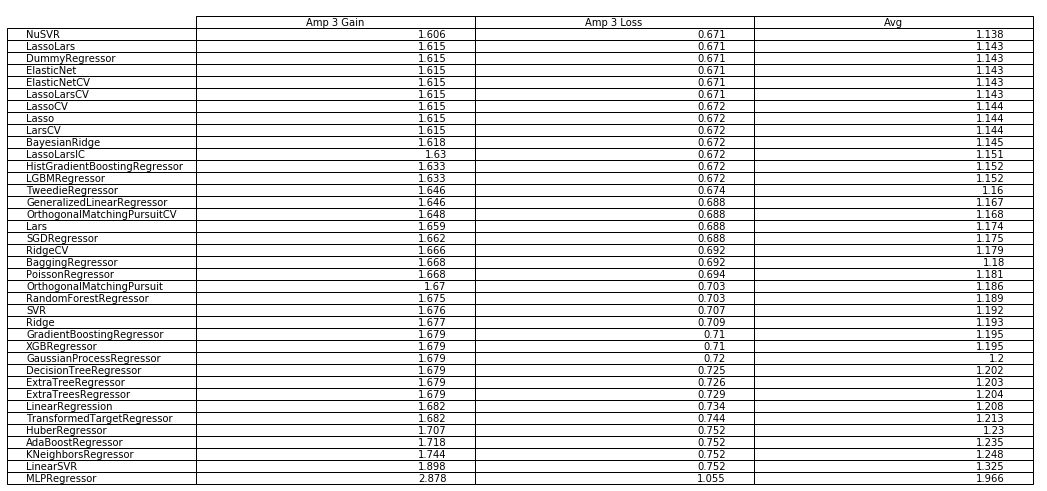

In [8]:
for i in range(ampNumber):
    drawTable(i)
    
print("Link average error: {}".format(avgSum / ampNumber))
print("Balanced dataset with {} entries".format(len(balancedDataset)))